# Information Retreival
In countries following the Common Law system (e.g., India, UK, Canada, Australia, andmany others), there are two primary sources of law -- (a) Statutes which are the written laws(e.g. IPC Section 302, Constitution Article 19) and (b) Precedents or judgements of priorcases delivered by a court, which involve similar legal facts and issues are the current case,but are not directly indicated in the written law.While working on a new case a legal practitioner often relies on these statutes andprecedents to understand how the Court has discussed, argued and behaved in similarscenarios. This task is aimed at creating retrieval systems capable of addressing thisproblem 
<b>Note: </b>For this purpose the data set is taken from the kaggle


In [14]:
# Importing the esse tial libraries
import numpy as np 
import pandas as pd 
import glob #to retrieve a list of file or directory paths matching a specified pattern
import csv
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 1) Data Handling
First we contain all the the case files in a single CSV file for a better understanding.
<b>Note: </b> All the path are taken according to the directory in your local device 

In [15]:
case_files = glob.glob('C:/Users/UR/Desktop/IR/IR-LegPrec/Object_casedocs/*') #After running this code, the case_files variable will contain a list of file paths for all files in the specified directory. 
with open("object_casedocs.csv", "w") as output_file:
    writer = csv.writer(output_file)
    for f in case_files :
        with open(f,"r") as input_file:
            writer.writerow([" ".join([line.strip() for line in input_file])])
            
doc_array = os.listdir('C:/Users/UR/Desktop/IR/IR-LegPrec/Object_casedocs/')#to retrieve a list of all items (both files and directories) present in the specified directory
df_filename = pd.DataFrame(doc_array, columns = ['docID'])
df_filename

docID
0        C1.txt
1       C10.txt
2      C100.txt
3     C1000.txt
4     C1001.txt
...         ...
3252   C995.txt
3253   C996.txt
3254   C997.txt
3255   C998.txt
3256   C999.txt

[3257 rows x 1 columns]

In [16]:
# Next we store all the training query data and their relevant document data which is provided to us
relevance_csv = pd.read_csv('C:/Users/UR/Desktop/IR/IR-LegPrec/relevance_judgements_train.txt', delimiter = " ", header = None)
relevance_csv.columns = ["Query Number", "Q0", "docID", "Relevance score"]
relevance_csv = relevance_csv.drop(columns = ["Q0"])
relevance_csv

Query Number  docID  Relevance score
0           AILA_Q1   C168                0
1           AILA_Q1   C382                0
2           AILA_Q1   C428                0
3           AILA_Q1   C949                0
4           AILA_Q1  C2303                0
...             ...    ...              ...
145695     AILA_Q50  C1367                0
145696     AILA_Q50  C2079                0
145697     AILA_Q50  C2066                0
145698     AILA_Q50  C1951                0
145699     AILA_Q50  C1111                0

[145700 rows x 3 columns]

In [17]:
#Before preprocessing text in docs let us see how our data looks like!
df = pd.read_csv('object_casedocs.csv', header = None)
df.columns = ["Text"]
df = pd.concat([df_filename,df], axis = 1)
df

docID                                               Text
0        C1.txt  Masud Khan v State Of Uttar Pradesh Supreme Co...
1       C10.txt  Prabhakaran Nair, Etc. v State Of Tamil Nadu A...
2      C100.txt  Hiten P. Dalal v Bratindranath Banerjee Suprem...
3     C1000.txt  Ashok Kumar and Others v State of Tamil Nadu S...
4     C1001.txt  Ashok Dhingra v N.C.T. of Delhi Supreme Court ...
...         ...                                                ...
3252   C995.txt  Rajendra Singh v State of Uttaranchal Supreme ...
3253   C996.txt  Food Corporation Of India & Anr v Seil Ltd. & ...
3254   C997.txt  State of Kerala v Sasi Supreme Court of India ...
3255   C998.txt  Columbia Sportswear Company v Director Of Inco...
3256   C999.txt  Bharat Gurjar and others v State of Rajasthan ...

[3257 rows x 2 columns]

In [18]:
df.shape # we got a 3257-by-2 ordered matrix

(3257, 2)

In [19]:
df.info

<bound method DataFrame.info of           docID                                               Text
0        C1.txt  Masud Khan v State Of Uttar Pradesh Supreme Co...
1       C10.txt  Prabhakaran Nair, Etc. v State Of Tamil Nadu A...
2      C100.txt  Hiten P. Dalal v Bratindranath Banerjee Suprem...
3     C1000.txt  Ashok Kumar and Others v State of Tamil Nadu S...
4     C1001.txt  Ashok Dhingra v N.C.T. of Delhi Supreme Court ...
...         ...                                                ...
3252   C995.txt  Rajendra Singh v State of Uttaranchal Supreme ...
3253   C996.txt  Food Corporation Of India & Anr v Seil Ltd. & ...
3254   C997.txt  State of Kerala v Sasi Supreme Court of India ...
3255   C998.txt  Columbia Sportswear Company v Director Of Inco...
3256   C999.txt  Bharat Gurjar and others v State of Rajasthan ...

[3257 rows x 2 columns]>

We make a list of most frequent words that will enact as stop words in our case and we will remove them to make our model work more efficiently

In [20]:
CHARS_TO_REMOVE = list('''.()"',-:;''')
VOCAB = {}

In [21]:
#This function takes a line of text as input and removes specific characters defined in the CHARS_TO_REMOVE list.
#It then returns the sanitized line.
def sanitize_line(line):
    for char_to_remove in CHARS_TO_REMOVE:
        line = line.replace(char_to_remove, ' ')
    return(line)

def plot_most_freq(points):#to plot a bar chart of the most frequent words in a given list of points
    x = [word[0] for word in points[:20]]
    y = [count[1] for count in points[:20]]
    df1 = pd.DataFrame(list(zip(x, y)), columns =['Word', 'Frequency'])
    
    sns.set_theme(style="darkgrid")
    sns.set(rc={'figure.figsize':(20,10)})
    sns.barplot(data = df1, x = 'Word', y = 'Frequency')
    plt.show()
#This function reads a text file specified by filename and processes its content. It sanitizes each line using the sanitize_line().
def fetch_corpus_from_file(filename):
    if filename.endswith(".txt"):
        with open("C:/Users/UR/Desktop/IR/IR-LegPrec/Object_casedocs/{}".format(filename)) as f:
            for line in f.readlines():
                line = sanitize_line(line)
                words = line.lower().split()
                for word in words:
                    word = word.strip()
                    if word in VOCAB:
                        VOCAB[word] += 1
                    else:
                        VOCAB[word] = 1
#It iterates through each file in the directory and updates the VOCAB dictionary.
def fetch_corpus():
    cnt = 0
    for filename in os.listdir("C:/Users/UR/Desktop/IR/IR-LegPrec/Object_casedocs"):
        cnt = cnt + 1
        fetch_corpus_from_file(filename)
    print(cnt)


3257
the 1045844
of 536320
to 293305
and 260783
in 247644
that 170388
a 156205
was 125073
is 124682
by 120456
on 104382
be 100339
for 91825
as 85739
court 85404
it 83535
not 80983
with 57995
or 56461
this 55772
no 51625
85182


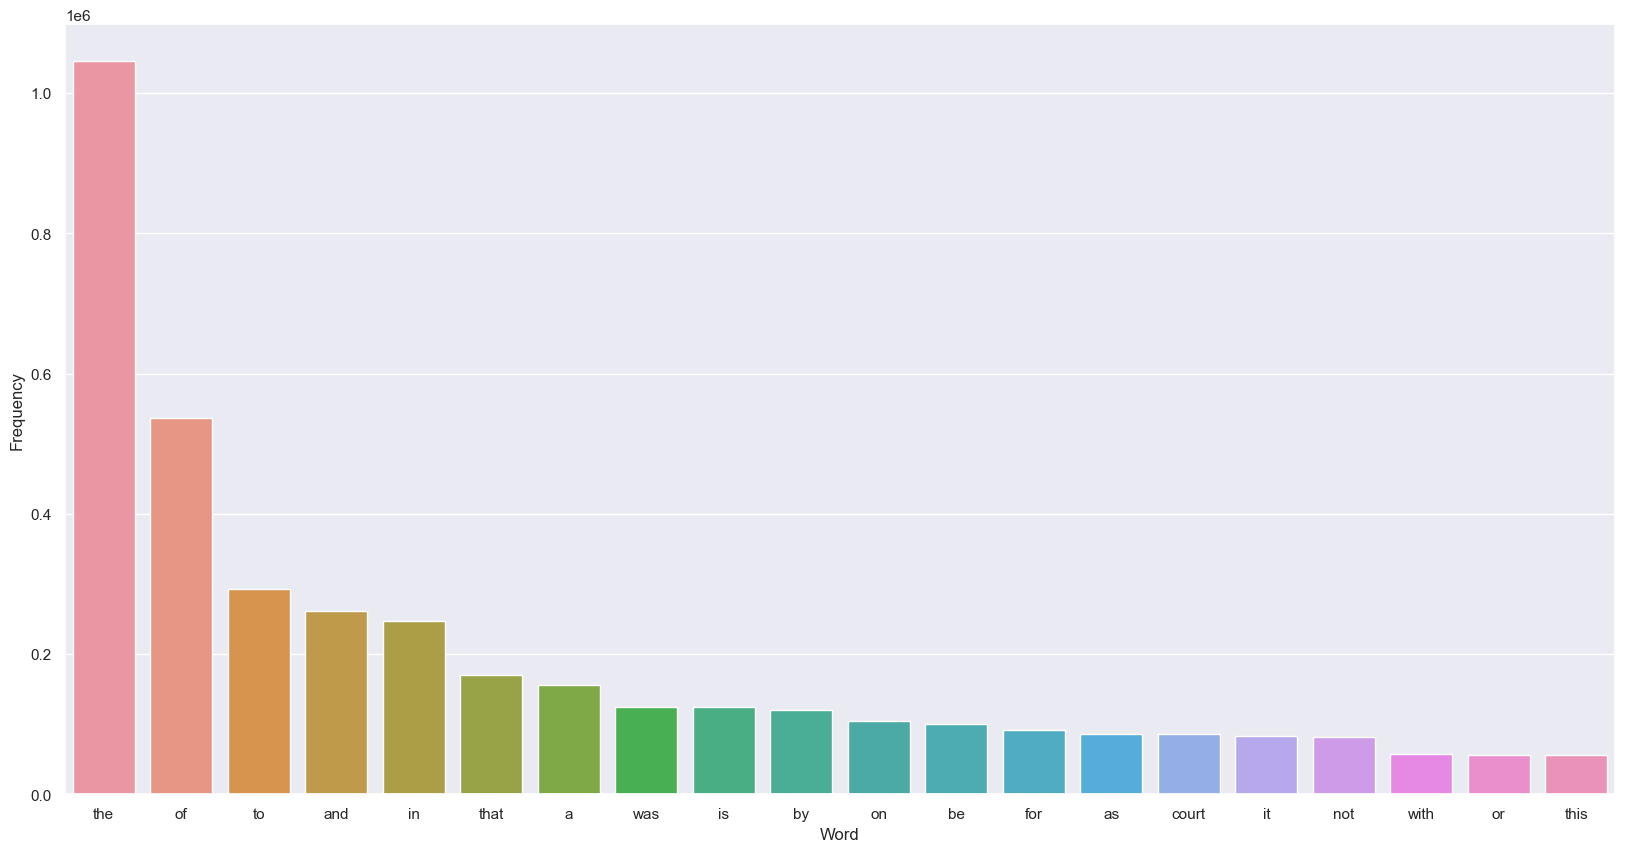

In [22]:
fetch_corpus()
counter = 0
# Now to contain the sorted key-value pairs based on the frequencies of words in descending order
SORTED_VOCAB = sorted(VOCAB.items(), key=lambda k: k[1], reverse=True) #
for (word, count) in SORTED_VOCAB:
    print(word, count)
    counter += 1
    if counter > 20:
        break
print(len(VOCAB))
plot_most_freq(SORTED_VOCAB)

# 2) Preprocessing Text in Docs
Text preprocessing is done in following 4 steps:
1) Convert all sentences to lowercase, remove punctuation and any special characters
2) Remove all stopwords
3) Stemming (Porter Stemming)
4) Lemmatization¶

First we define the function use to preprocess the text.
Here we NLTK (Natural language toolkit) package for removing Stopwords, Stemming and Lemmatization.

Later we will shift to Industrial level NLP toolkit named SpaCy

In [23]:
def preprocess_text(text, flagStemm = True, flagLemmatize = True, list_of_stopwords = None):

    processed_text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    # Tokenization(convert from string to List)
    list_of_text = processed_text.split()
    
    # Remove all stopwords
    if list_of_stopwords is not None:
        list_of_text = [word for word in list_of_text if word not in
                   list_of_stopwords]
    
    # Lemmatization
    if flagLemmatize == True:
        lem = nltk.stem.WordNetLemmatizer()
        list_of_text = [lem.lemmatize(word) for word in list_of_text]
    
    # Porter Stemming
    if flagStemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        list_of_text = [ps.stem(word) for word in list_of_text]
        
    # back to string from list
    processed_text = " ".join(list_of_text)
    return processed_text

In [24]:
# Removing the stopwords
df['Processed Text'] = df['Text'].apply(lambda x: preprocess_text(x, 
                                                                list_of_stopwords= 
                                                          ['the', 'of', 'to', 'and', 'in' ,'that', 'a' ,'was', 'is' ,'by' ], 
                                                                  flagStemm = False, flagLemmatize=True))

In [25]:
df #New data with processed text

docID                                               Text  \
0        C1.txt  Masud Khan v State Of Uttar Pradesh Supreme Co...   
1       C10.txt  Prabhakaran Nair, Etc. v State Of Tamil Nadu A...   
2      C100.txt  Hiten P. Dalal v Bratindranath Banerjee Suprem...   
3     C1000.txt  Ashok Kumar and Others v State of Tamil Nadu S...   
4     C1001.txt  Ashok Dhingra v N.C.T. of Delhi Supreme Court ...   
...         ...                                                ...   
3252   C995.txt  Rajendra Singh v State of Uttaranchal Supreme ...   
3253   C996.txt  Food Corporation Of India & Anr v Seil Ltd. & ...   
3254   C997.txt  State of Kerala v Sasi Supreme Court of India ...   
3255   C998.txt  Columbia Sportswear Company v Director Of Inco...   
3256   C999.txt  Bharat Gurjar and others v State of Rajasthan ...   

                                         Processed Text  
0     masud khan v state uttar pradesh supreme court...  
1     prabhakaran nair etc v state tamil nadu or sup...  
2     hiten p dalal v bratindranath banerjee supreme...  
3     ashok kumar others v state tamil nadu supreme ...  
4     ashok dhingra v nct delhi supreme court india ...  
...                                                 ...  
3252  rajendra singh v state uttaranchal supreme cou...  
3253  food corporation india anr v seil ltd or supre...  
3254  state kerala v sasi supreme court india 31 oct...  
3255  columbia sportswear company v director income ...  
3256  bharat gurjar others v state rajasthan supreme...  

[3257 rows x 3 columns]

In [26]:
clean_text = df["Processed Text"]
clean_text

0       masud khan v state uttar pradesh supreme court...
1       prabhakaran nair etc v state tamil nadu or sup...
2       hiten p dalal v bratindranath banerjee supreme...
3       ashok kumar others v state tamil nadu supreme ...
4       ashok dhingra v nct delhi supreme court india ...
                              ...                        
3252    rajendra singh v state uttaranchal supreme cou...
3253    food corporation india anr v seil ltd or supre...
3254    state kerala v sasi supreme court india 31 oct...
3255    columbia sportswear company v director income ...
3256    bharat gurjar others v state rajasthan supreme...
Name: Processed Text, Length: 3257, dtype: object

# 3) Preprocessing Text in Queries

Creating a training dataframe from the train queries given

In [28]:
train = pd.read_csv("C:/Users/UR/Desktop/IR/IR-LegPrec/Query_doc_train.txt",delimiter = "|",header=None)
train.columns = ["Query_Number","None", "Query"]
train=train.drop(columns=["Query_Number","None"])
train

Query
0   The appellant on February 9, 1961 was appointe...
1   The appellant before us was examined as prime ...
2   This appeal arises from the judgment of the le...
3   The Petitioner was married to the Respondent N...
4   This appeal is preferred against the judgment ...
5   On 19.3.1999, SI P1 along Ct. P2 went to Villa...
6   This criminal appeal is directed against the j...
7   This appeal, by special leave, has been prefer...
8   The complainant P1 filed a Special Leave Petit...
9   The four appellants, along with P1 son of P2, ...
10  The detenu P1, a French national, at the relev...
11  The petitioner has been under detention pursua...
12  This is an appeal with a certificate granted b...
13  P1 is before us being aggrieved by and dissati...
14  The appellants are five in number and they hav...
15  The appellant P1 is convicted by the Additiona...
16  facts of the matter, as is evident from the pr...
17  These appeals involve a pure question of law a...
18  This appeal is preferred by the appellants aga...
19  This appeal by special leave is directed again...
20  Challenge in this appeal is to the judgment of...
21  Assailing the legal acceptability of the judgm...
22  The petitioner is a firm carrying on business ...
23  These appeals are directed against the judgmen...
24  These appeals involving common questions of la...
25  The hearing before us now relates to certain o...
26  Appellant before us was detained. He is the Ma...
27  Challenge in this appeal is to the judgment of...
28  This appeal has been preferred against the jud...
29  That the deceased P1 got married to P2, the 2n...
30  This appeal by special leave is directed again...
31  On 9th May, 2004, the marriage of the daughter...
32  This is an appeal by special leave from the ju...
33  These writ petitions are filed as Public Inter...
34  Two appellants, who are brothers, along with t...
35  Interpretation and/or application of Medical B...
36  Appellants call in question legality of the ju...
37  The appellant herein is a Senior Manager in a ...
38  Challenge in this appeal is to the order of a ...
39  Having been selected by the Public Service Com...
40  Appellant calls in question legality of the ju...
41  This appeal arises out of the judgment dated 2...
42  Transfer Petition have been filed to transfer ...
43  This petition is by the State directed against...
44  The appellants were tried for offences on the ...
45  In this appeal by special leave the sole appel...
46  Challenge in this appeal is to the judgment of...
47  Whether sanction is required to initiate crimi...
48  Appellant was a Patwari working at village V1 ...
49  A peculiar feature of this appeal by special l...

In [30]:
#Preprocessing the queries as same as we did for docs
train['Processed Query'] = train['Query'].apply(lambda x: preprocess_text(x, 
list_of_stopwords= ['the', 'of', 'to', 'and', 'in' ,'that', 'a' ,'was', 'is' ,'by' ],flagStemm = False, flagLemmatize= True))
train

Query  \
0   The appellant on February 9, 1961 was appointe...   
1   The appellant before us was examined as prime ...   
2   This appeal arises from the judgment of the le...   
3   The Petitioner was married to the Respondent N...   
4   This appeal is preferred against the judgment ...   
5   On 19.3.1999, SI P1 along Ct. P2 went to Villa...   
6   This criminal appeal is directed against the j...   
7   This appeal, by special leave, has been prefer...   
8   The complainant P1 filed a Special Leave Petit...   
9   The four appellants, along with P1 son of P2, ...   
10  The detenu P1, a French national, at the relev...   
11  The petitioner has been under detention pursua...   
12  This is an appeal with a certificate granted b...   
13  P1 is before us being aggrieved by and dissati...   
14  The appellants are five in number and they hav...   
15  The appellant P1 is convicted by the Additiona...   
16  facts of the matter, as is evident from the pr...   
17  These appeals involve a pure question of law a...   
18  This appeal is preferred by the appellants aga...   
19  This appeal by special leave is directed again...   
20  Challenge in this appeal is to the judgment of...   
21  Assailing the legal acceptability of the judgm...   
22  The petitioner is a firm carrying on business ...   
23  These appeals are directed against the judgmen...   
24  These appeals involving common questions of la...   
25  The hearing before us now relates to certain o...   
26  Appellant before us was detained. He is the Ma...   
27  Challenge in this appeal is to the judgment of...   
28  This appeal has been preferred against the jud...   
29  That the deceased P1 got married to P2, the 2n...   
30  This appeal by special leave is directed again...   
31  On 9th May, 2004, the marriage of the daughter...   
32  This is an appeal by special leave from the ju...   
33  These writ petitions are filed as Public Inter...   
34  Two appellants, who are brothers, along with t...   
35  Interpretation and/or application of Medical B...   
36  Appellants call in question legality of the ju...   
37  The appellant herein is a Senior Manager in a ...   
38  Challenge in this appeal is to the order of a ...   
39  Having been selected by the Public Service Com...   
40  Appellant calls in question legality of the ju...   
41  This appeal arises out of the judgment dated 2...   
42  Transfer Petition have been filed to transfer ...   
43  This petition is by the State directed against...   
44  The appellants were tried for offences on the ...   
45  In this appeal by special leave the sole appel...   
46  Challenge in this appeal is to the judgment of...   
47  Whether sanction is required to initiate crimi...   
48  Appellant was a Patwari working at village V1 ...   
49  A peculiar feature of this appeal by special l...   

                                      Processed Query  
0   appellant on february 9 1961 appointed a an of...  
1   appellant before u examined a prime witness tr...  
2   this appeal arises from judgment learned singl...  
3   petitioner married respondent no2 on 27th nove...  
4   this appeal preferred against judgment dated 1...  
5   on 1931999 si p1 along ct p2 went village v1 w...  
6   this criminal appeal directed against judgment...  
7   this appeal special leave ha been preferred ag...  
8   complainant p1 filed special leave petition th...  
9   four appellant along with p1 son p2 were joint...  
10  detenu p1 french national at relevant time emp...  
11  petitioner ha been under detention pursuant or...  
12  this an appeal with certificate granted judici...  
13  p1 before u being aggrieved dissatisfied with ...  
14  appellant are five number they have filed this...  
15  appellant p1 convicted additional session judg...  
16  fact matter a evident from present writ petiti...  
17  these appeal involve pure question law a wheth...  
18  this appeal preferred appellant against judgme...  
19  this appeal spec

# 4) Ranking Relevant Documents for Train Queries

In [31]:
!pip install rank_bm25

In [36]:
processed_query_array = [0]*50
processed_corpus_array = [0]*3257

# Storing the preprocessed results in 1D arrays
training_array=df.iloc[:,1:].values

for i in range(3257):
    processed_corpus_array[i] = training_array[i][0]

query_array=train.iloc[:,1:].values

for i in range(50):
    processed_query_array[i] = query_array[i][0]

In [37]:
ID = df["docID"]
ID = ID.str.rstrip('.txt')
ID

0          C1
1         C10
2        C100
3       C1000
4       C1001
        ...  
3252     C995
3253     C996
3254     C997
3255     C998
3256     C999
Name: docID, Length: 3257, dtype: object

In [38]:
# First we show a result if in case one of the docs is searched as a query. BM25 returns top 10 relevant results,with the original doc being the first one
relevance_csv = relevance_csv.loc[relevance_csv['Relevance score'] == 1]
relevance_csv

Query Number docID  Relevance score
1192        AILA_Q1   C14                1
2274        AILA_Q1    C9                1
3076        AILA_Q2   C27                1
3676        AILA_Q2   C22                1
6033        AILA_Q3    C1                1
...             ...   ...              ...
140861     AILA_Q49   C38                1
142203     AILA_Q49   C76                1
142450     AILA_Q49   C92                1
143069     AILA_Q50   C27                1
143844     AILA_Q50   C22                1

[195 rows x 3 columns]

We return the top 10 relevant documents for each train query

In [41]:
VOCAB = {}

def store_term_df_values_utility(filename):
    per_file = set()
    if filename.endswith(".txt"):
        with open("C:/Users/UR/Desktop/IR/IR-LegPrec/Object_casedocs/{}".format(filename)) as f:
            for line in f.readlines():
                line = sanitize_line(line)
                words = line.lower().split()
                for word in words:
                    word = word.strip()
                    per_file.add(word)
                    
    for word in per_file:
        if word in VOCAB:
            VOCAB[word] += 1
        else:
            VOCAB[word] = 1
            
def store_term_df_values():
    for filename in os.listdir("C:/Users/UR/Desktop/IR/IR-LegPrec/Object_casedocs"):
        store_term_df_values_utility(filename)

store_term_df_values()

In [42]:
test = pd.read_csv("C:/Users/UR/Desktop/IR/IR-LegPrec/Query_doc_test.txt",delimiter = "|",header=None)
test.columns = ["Query_Number","None", "Query"]
test=test.drop(columns=["Query_Number","None"])
test

Query
0  X was suffering from a headache. He went to Dr...
1  A manufacturing company has 500 workmen. A dis...
2  Food Inspector P1 collected a sample of red ch...
3  A1 (currently resides in USA) married R2 in Ja...
4  In a village five notifications were passed fo...
5  The appellants signed a contract with a foreig...
6  On a festival day, SB and her son ST went to t...
7  The Customs Officers intercepted two passenger...
8  Income Tax Officer P1 threatned C1 with reopen...
9  J is the brother of K. R and V are cousin brot...

In [43]:
test['Processed Query'] = test['Query'].apply(lambda x: preprocess_text(x, 
list_of_stopwords= ['the', 'of', 'to', 'and', 'in' ,'that', 'a' ,'was', 'is' ,'by' ],flagStemm = False, flagLemmatize=True))
test

Query  \
0  X was suffering from a headache. He went to Dr...   
1  A manufacturing company has 500 workmen. A dis...   
2  Food Inspector P1 collected a sample of red ch...   
3  A1 (currently resides in USA) married R2 in Ja...   
4  In a village five notifications were passed fo...   
5  The appellants signed a contract with a foreig...   
6  On a festival day, SB and her son ST went to t...   
7  The Customs Officers intercepted two passenger...   
8  Income Tax Officer P1 threatned C1 with reopen...   
9  J is the brother of K. R and V are cousin brot...   

                                     Processed Query  
0  x suffering from headache he went dr d who aft...  
1  manufacturing company ha 500 workman dispute a...  
2  food inspector p1 collected sample red chilli ...  
3  a1 currently resides usa married r2 january 20...  
4  village five notification were passed for acqu...  
5  appellant signed contract with foreign supplie...  
6  on festival day sb her son st went market for ...  
7  custom officer intercepted two passenger at ai...  
8  income tax officer p1 threatned c1 with reopen...  
9  j brother k r v are cousin brother 3 year befo...

In [44]:
processed_test_query_array = [0]*10
query_array=test.iloc[:,1:].values

for i in range(10):
    processed_test_query_array[i] = query_array[i][0]

In [45]:
# Jaccard Similarity 
"""to measure the similarity between two sets for information retrieval 
by comparing the similarity between documents based on the words they contain"""
def jaccard_similarity(doc1, doc2):
    # List the unique words in a document
    words_doc1 = set(doc1.lower().split())
    words_doc2 = set(doc2.lower().split())

    # Find the intersection of words list of doc1 & doc2
    intersection = words_doc1.intersection(words_doc2)

    # Find the union of words list of doc1 & doc2
    union = words_doc1.union(words_doc2)

    # Calculate Jaccard similarity score
    # using length of intersection set divided by length of union set
    return float(len(intersection)) / len(union)

In [46]:
from itertools import islice
"""to calculate the Jaccard similarity scores between queries and documents,
ranking documents based on their similarity scores, and then evaluating 
the effectiveness of the ranking by counting how many relevant documents 
are included in the top-ranked results for each query."""
umap = {} # initislizing an empty directory
count = 0 
for j in range(50):
    i = 0
    rank_list = []
    relevant_doc = relevance_csv.loc[relevance_csv['Query Number'] == "AILA_Q"+str(j+1)]["docID"]
    for doc in processed_corpus_array:
        umap[ID[i]] = jaccard_similarity(processed_query_array[j], doc)
        i = i + 1
    sorted_umap = sorted(umap.items(), key = lambda k: k[1], reverse = True)
    for key,value in islice(sorted_umap,10):
        rank_list.append(key)
    
    print(rank_list)
    for j in rank_list:
        for k in relevant_doc:
              if (j==k):
                    count=count+1
count

['C3065', 'C1613', 'C3014', 'C2998', 'C1568', 'C2380', 'C2564', 'C3057', 'C809', 'C1466']
['C2424', 'C1325', 'C1838', 'C1153', 'C1626', 'C1355', 'C2245', 'C2765', 'C669', 'C1029']
['C2392', 'C2816', 'C1750', 'C3168', 'C1363', 'C2478', 'C794', 'C439', 'C3137', 'C2424']
['C2576', 'C3133', 'C1591', 'C654', 'C2523', 'C1097', 'C1670', 'C875', 'C2585', 'C669']
['C1817', 'C623', 'C402', 'C1626', 'C2196', 'C1140', 'C1352', 'C1934', 'C404', 'C329']
['C2823', 'C1083', 'C1352', 'C3017', 'C2064', 'C3187', 'C2417', 'C1029', 'C1563', 'C1170']
['C1630', 'C2392', 'C1750', 'C1998', 'C794', 'C1153', 'C1644', 'C1363', 'C2693', 'C2816']
['C1996', 'C685', 'C1225', 'C3017', 'C233', 'C2238', 'C2888', 'C2632', 'C1941', 'C3056']
['C1814', 'C1468', 'C3187', 'C2792', 'C351', 'C404', 'C430', 'C1323', 'C1816', 'C1157']
['C782', 'C2890', 'C2693', 'C2005', 'C1068', 'C1965', 'C797', 'C1948', 'C31', 'C2816']
['C737', 'C3019', 'C418', 'C2937', 'C2098', 'C2351', 'C2742', 'C913', 'C262', 'C1916']
['C1095', 'C1811', 'C148

8

In [47]:
# By finding the mean average percision 
MAP = count/(50*10)
MAP

0.016

# Now using the NLP techniques 

In [48]:
# Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [49]:
#corpus_array_processed
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(processed_corpus_array)]

In [50]:
model = Doc2Vec(tagged_data, vector_size=20, window=2, min_count=1, workers=4, epochs = 50)

In [51]:
count = 0
for i in range(50):
    for j in model.docvecs.most_similar(positive=[model.infer_vector(word_tokenize(processed_query_array[i]))],topn=10)[0][0]:
        temp = relevance_csv.loc[relevance_csv['Query Number'] == "AILA_Q"+str(i+1)]["docID"]
        for k in temp.str.replace('C', ''):
            if (j==k):
                count=count+1

print(count)

C:\Users\UR\AppData\Local\Temp\ipykernel_2236\1878880793.py:3: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  for j in model.docvecs.most_similar(positive=[model.infer_vector(word_tokenize(processed_query_array[i]))],topn=10)[0][0]:


3


In [52]:
Precision = count/500
Recall = count/195

print(Precision)
print(Recall)

0.006
0.015384615384615385


In [53]:
#BM25L
tokenized_corpus_array = [doc.split(" ") for doc in processed_corpus_array]
from rank_bm25 import BM25L
bm25L = BM25L(tokenized_corpus_array)
bm25L

In [54]:
count = 0
for i in range(50):
    retrieved_docs = bm25L.get_top_n(processed_query_array[i].split(" "), ID, n=10)
    relevant_doc = relevance_csv.loc[relevance_csv['Query Number'] == "AILA_Q"+str(i+1)]["docID"]
    print("AILA_Q"+str(i+1))
    print(retrieved_docs)
    for j in retrieved_docs:
        for k in relevant_doc:
              if (j==k):
                    count=count+1
count

AILA_Q1
['C169', 'C3000', 'C1751', 'C14', 'C2060', 'C54', 'C1651', 'C855', 'C1714', 'C2642']
AILA_Q2
['C3000', 'C169', 'C1853', 'C2211', 'C1777', 'C2316', 'C162', 'C2985', 'C1302', 'C2722']
AILA_Q3
['C2060', 'C3000', 'C1302', 'C6', 'C169', 'C1777', 'C1257', 'C63', 'C241', 'C2944']
AILA_Q4
['C3000', 'C169', 'C2985', 'C1302', 'C2582', 'C1777', 'C913', 'C162', 'C1558', 'C2944']
AILA_Q5
['C3000', 'C1302', 'C169', 'C1777', 'C384', 'C2944', 'C1257', 'C538', 'C2060', 'C2985']
AILA_Q6
['C3000', 'C1302', 'C1777', 'C169', 'C1311', 'C1257', 'C2944', 'C538', 'C3198', 'C2722']
AILA_Q7
['C3000', 'C141', 'C2020', 'C1714', 'C2060', 'C1777', 'C169', 'C128', 'C54', 'C1302']
AILA_Q8
['C169', 'C3000', 'C1302', 'C973', 'C453', 'C1777', 'C3198', 'C2722', 'C1183', 'C2161']
AILA_Q9
['C3000', 'C1302', 'C1777', 'C169', 'C384', 'C1257', 'C538', 'C2944', 'C1311', 'C2985']
AILA_Q10
['C1302', 'C3000', 'C169', 'C2944', 'C2985', 'C141', 'C54', 'C1777', 'C2328', 'C538']
AILA_Q11
['C360', 'C2938', 'C2936', 'C2257', 'C7

17

In [55]:
mean_average_precision = count/(50*10)
print("MAP : ", mean_average_precision)

MAP :  0.034


In [56]:
#BM25Plus
from rank_bm25 import BM25Plus
bm25Plus = BM25Plus(tokenized_corpus_array)
bm25Plus

In [57]:
count = 0
for i in range(50):
    retrieved_docs = bm25Plus.get_top_n(processed_query_array[i].split(" "), ID, n=10)
    relevant_doc = relevance_csv.loc[relevance_csv['Query Number'] == "AILA_Q"+str(i+1)]["docID"]
    print("AILA_Q"+str(i+1))
    print(retrieved_docs)
    for j in retrieved_docs:
        for k in relevant_doc:
              if (j==k):
                    count=count+1
count

AILA_Q1
['C1651', 'C39', 'C182', 'C1389', 'C1837', 'C352', 'C2544', 'C2281', 'C2517', 'C128']
AILA_Q2
['C2316', 'C2846', 'C823', 'C2462', 'C2313', 'C2765', 'C1623', 'C2657', 'C3193', 'C2311']
AILA_Q3
['C103', 'C2322', 'C2926', 'C2431', 'C2928', 'C2347', 'C417', 'C294', 'C1147', 'C246']
AILA_Q4
['C2726', 'C2862', 'C2866', 'C2121', 'C2747', 'C1381', 'C2303', 'C605', 'C162', 'C1154']
AILA_Q5
['C625', 'C2259', 'C300', 'C1899', 'C1538', 'C1569', 'C1959', 'C2861', 'C836', 'C2310']
AILA_Q6
['C822', 'C356', 'C2109', 'C1096', 'C2115', 'C1053', 'C926', 'C159', 'C1295', 'C860']
AILA_Q7
['C128', 'C2853', 'C2365', 'C39', 'C1383', 'C2313', 'C1396', 'C364', 'C1623', 'C2721']
AILA_Q8
['C363', 'C1154', 'C2898', 'C2738', 'C459', 'C2571', 'C2102', 'C2354', 'C156', 'C1164']
AILA_Q9
['C1472', 'C2123', 'C2109', 'C2827', 'C2526', 'C2229', 'C1344', 'C625', 'C2443', 'C2085']
AILA_Q10
['C1874', 'C2761', 'C2260', 'C1302', 'C892', 'C1569', 'C1974', 'C54', 'C1749', 'C2425']
AILA_Q11
['C2017', 'C1354', 'C73', 'C293

23

In [58]:
mean_average_precision = count/(50*10)
print("MAP : ", mean_average_precision)

MAP :  0.046


In [59]:
# BM25Plus (with rare terms as search keys)
count = 0
for i in range(50):
    list_of_terms = {}
    for word in processed_query_array[i].split(" "):
        if word in VOCAB.keys():
            list_of_terms[word] = VOCAB[word]   
    search_keywords =[key for key,value in sorted(list_of_terms.items(), key = lambda k: k[1])][:150]
    retrieved_docs = bm25Plus.get_top_n(search_keywords, ID, n=10)
    relevant_doc = relevance_csv.loc[relevance_csv['Query Number'] == "AILA_Q"+str(i+1)]["docID"]
    print("AILA_Q"+str(i+1))
    print(retrieved_docs)
    for j in retrieved_docs:
        for k in relevant_doc:
              if (j==k):
                    count=count+1
count

AILA_Q1
['C2140', 'C1651', 'C2517', 'C13', 'C39', 'C867', 'C514', 'C723', 'C30', 'C1837']
AILA_Q2
['C2462', 'C2316', 'C2846', 'C823', 'C2311', 'C2765', 'C993', 'C2798', 'C2955', 'C3193']
AILA_Q3
['C103', 'C2322', 'C294', 'C2431', 'C2926', 'C2928', 'C2347', 'C1036', 'C414', 'C417']
AILA_Q4
['C605', 'C2303', 'C1728', 'C2726', 'C2121', 'C2862', 'C62', 'C363', 'C1154', 'C2747']
AILA_Q5
['C2259', 'C1959', 'C625', 'C300', 'C1217', 'C2827', 'C2518', 'C1652', 'C1569', 'C2123']
AILA_Q6
['C822', 'C1096', 'C356', 'C1295', 'C926', 'C649', 'C1053', 'C2115', 'C59', 'C159']
AILA_Q7
['C128', 'C2365', 'C1396', 'C2328', 'C2853', 'C1660', 'C236', 'C39', 'C1383', 'C2195']
AILA_Q8
['C363', 'C1154', 'C2898', 'C403', 'C2354', 'C1329', 'C2102', 'C1254', 'C459', 'C2571']
AILA_Q9
['C1388', 'C926', 'C2102', 'C419', 'C2706', 'C2779', 'C1302', 'C2229', 'C1102', 'C1053']
AILA_Q10
['C1874', 'C2526', 'C1302', 'C2761', 'C54', 'C2260', 'C2425', 'C1974', 'C1385', 'C568']
AILA_Q11
['C73', 'C1354', 'C2017', 'C2938', 'C250

25

In [60]:
mean_average_precision = count/(50*10)
print("MAP : ", mean_average_precision)

MAP :  0.05


# 5) Generating relevant documents and trec_top_file for Test Queries

In [61]:
from collections import OrderedDict
list_of_docs = ID.values
with open("trec_top_file_bm25L.txt", "w") as output_file:
    for i in range(10):
        counter = 1
        map_doc_scores = {} 
        sorted_scores = {}
        retrieved_scores = bm25L.get_scores(processed_test_query_array[i].split(" "))
        for j in range(3257):
            map_doc_scores[retrieved_scores[j]] = list_of_docs[j]
            sorted_scores = OrderedDict(sorted(map_doc_scores.items(), reverse = True))
        for key,value in sorted_scores.items():
            output_file.write("AILA_Q"+ str(i+1) + " Q0 " + value + " " + str(counter) + " " + str(key) + " bm25L\n")
            counter = counter + 1

In [62]:
with open("trec_top_file_bm25Plus.txt", "w") as output_file:
    for i in range(10):
        counter = 1
        map_doc_scores = {} 
        sorted_scores = {}
        retrieved_scores = bm25Plus.get_scores(processed_test_query_array[i].split(" "))
        for j in range(3257):
            map_doc_scores[retrieved_scores[j]] = list_of_docs[j]
            sorted_scores = OrderedDict(sorted(map_doc_scores.items(), reverse = True))
        for key,value in sorted_scores.items():
            output_file.write("AILA_Q"+ str(i+1) + " Q0 " + value + " " + str(counter) + " " + str(key) + " bm25Plus\n")
            counter = counter + 1

In [63]:
with open("trec_top_file_doc2vec.txt", "w") as output_file:
    for i in range(10):
        counter = 1
        map_doc_scores = {} 
        sorted_scores = {}
        retrieved_scores = model.docvecs.most_similar(positive=[model.infer_vector(word_tokenize(processed_test_query_array[i]))],topn=3257)
        for j in range(3257):
            map_doc_scores[retrieved_scores[j][0]] = retrieved_scores[j][1]
        for key,value in map_doc_scores.items():
            output_file.write("AILA_Q"+ str(i+1) + " Q0 " + str(value) + " " + str(counter) + " C" + str(key) + " doc2vec\n")
            counter = counter + 1

C:\Users\UR\AppData\Local\Temp\ipykernel_2236\2195235432.py:6: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  retrieved_scores = model.docvecs.most_similar(positive=[model.infer_vector(word_tokenize(processed_test_query_array[i]))],topn=3257)


In [64]:
umap = {}
count = 0 
with open("trec_top_file_jaccard.txt", "w") as output_file:
    for j in range(10):
        i = 0
        counter = 1
        relevant_doc = relevance_csv.loc[relevance_csv['Query Number'] == "AILA_Q"+str(j+1)]["docID"]
        for doc in processed_corpus_array:
            umap[ID[i]] = jaccard_similarity(processed_test_query_array[j], doc)
            i = i + 1
        sorted_umap = sorted(umap.items(), key = lambda k: k[1], reverse = True)
        for key,value in sorted_umap:
            output_file.write("AILA_Q"+ str(i+1) + " Q0 " + str(value) + " " + str(counter) + " " + str(key) + " jaccard\n")
            counter = counter + 1

In [65]:
# Reading the files based on queries 
file_path = "trec_top_file_bm25L.txt"
with open(file_path, "r") as file:
    content = file.read()

# Print the content of the file
print(content)


AILA_Q1 Q0 C500 1 1901.9380989594936 bm25L
AILA_Q1 Q0 C486 2 1771.7971531931278 bm25L
AILA_Q1 Q0 C1417 3 1246.4025973976204 bm25L
AILA_Q1 Q0 C387 4 1166.433406135437 bm25L
AILA_Q1 Q0 C2403 5 1165.8904191356935 bm25L
AILA_Q1 Q0 C2447 6 1141.9257049732762 bm25L
AILA_Q1 Q0 C1820 7 1018.4335124308017 bm25L
AILA_Q1 Q0 C1605 8 972.3791428022979 bm25L
AILA_Q1 Q0 C2310 9 926.6819566674596 bm25L
AILA_Q1 Q0 C1777 10 878.334171342825 bm25L
AILA_Q1 Q0 C3000 11 869.7176515206568 bm25L
AILA_Q1 Q0 C1815 12 840.0100825162677 bm25L
AILA_Q1 Q0 C529 13 832.7450155547217 bm25L
AILA_Q1 Q0 C995 14 830.1048716752036 bm25L
AILA_Q1 Q0 C2778 15 829.2231933562617 bm25L
AILA_Q1 Q0 C2036 16 819.7982427366403 bm25L
AILA_Q1 Q0 C1302 17 810.7474471070152 bm25L
AILA_Q1 Q0 C1148 18 752.0531752196503 bm25L
AILA_Q1 Q0 C2607 19 741.8543426967574 bm25L
AILA_Q1 Q0 C169 20 741.1213434999904 bm25L
AILA_Q1 Q0 C2229 21 738.3987729370704 bm25L
AILA_Q1 Q0 C1958 22 735.6300756385988 bm25L
AILA_Q1 Q0 C241 23 725.670872678468 bm25L


In [67]:
file_path = "trec_top_file_bm25Plus.txt"
with open(file_path, "r") as file:
    content = file.read()

# Print the content of the file
print(content)


AILA_Q1 Q0 C201 1 108.03428719003752 bm25Plus
AILA_Q1 Q0 C1529 2 107.82351625364296 bm25Plus
AILA_Q1 Q0 C2229 3 107.2707860759531 bm25Plus
AILA_Q1 Q0 C1448 4 107.15807345370764 bm25Plus
AILA_Q1 Q0 C500 5 106.58171256939475 bm25Plus
AILA_Q1 Q0 C1417 6 106.4605567217803 bm25Plus
AILA_Q1 Q0 C2880 7 105.87225559946589 bm25Plus
AILA_Q1 Q0 C2607 8 105.49015243860397 bm25Plus
AILA_Q1 Q0 C211 9 104.80201471103813 bm25Plus
AILA_Q1 Q0 C1815 10 104.67927898812802 bm25Plus
AILA_Q1 Q0 C995 11 104.62779173008185 bm25Plus
AILA_Q1 Q0 C1148 12 103.8788939993251 bm25Plus
AILA_Q1 Q0 C486 13 103.21321294986932 bm25Plus
AILA_Q1 Q0 C1648 14 102.54090314879134 bm25Plus
AILA_Q1 Q0 C746 15 102.38826181978918 bm25Plus
AILA_Q1 Q0 C2285 16 102.18028474792348 bm25Plus
AILA_Q1 Q0 C168 17 102.09552844542924 bm25Plus
AILA_Q1 Q0 C2209 18 101.90750487320845 bm25Plus
AILA_Q1 Q0 C2443 19 101.89142704486287 bm25Plus
AILA_Q1 Q0 C2518 20 101.14581556498575 bm25Plus
AILA_Q1 Q0 C2603 21 100.96435056776716 bm25Plus
AILA_Q1 Q0 

In [68]:
file_path = "trec_top_file_doc2vec.txt"
with open(file_path, "r") as file:
    content = file.read()

# Print the content of the file
print(content)


AILA_Q1 Q0 0.7382147908210754 1 C1561 doc2vec
AILA_Q1 Q0 0.7349933981895447 2 C1436 doc2vec
AILA_Q1 Q0 0.7288104891777039 3 C1609 doc2vec
AILA_Q1 Q0 0.7231797575950623 4 C1651 doc2vec
AILA_Q1 Q0 0.7074010968208313 5 C2704 doc2vec
AILA_Q1 Q0 0.7030311226844788 6 C3249 doc2vec
AILA_Q1 Q0 0.7022899389266968 7 C2136 doc2vec
AILA_Q1 Q0 0.7012951970100403 8 C378 doc2vec
AILA_Q1 Q0 0.7002719044685364 9 C2341 doc2vec
AILA_Q1 Q0 0.6975456476211548 10 C1331 doc2vec
AILA_Q1 Q0 0.695366621017456 11 C1537 doc2vec
AILA_Q1 Q0 0.6948142647743225 12 C3248 doc2vec
AILA_Q1 Q0 0.6910948753356934 13 C558 doc2vec
AILA_Q1 Q0 0.6882976293563843 14 C1488 doc2vec
AILA_Q1 Q0 0.6881635785102844 15 C418 doc2vec
AILA_Q1 Q0 0.6867246627807617 16 C83 doc2vec
AILA_Q1 Q0 0.6831339597702026 17 C2917 doc2vec
AILA_Q1 Q0 0.682442307472229 18 C1458 doc2vec
AILA_Q1 Q0 0.681344211101532 19 C1515 doc2vec
AILA_Q1 Q0 0.6793954372406006 20 C785 doc2vec
AILA_Q1 Q0 0.6790992021560669 21 C3153 doc2vec
AILA_Q1 Q0 0.6786341071128845 2

In [69]:
file_path = "trec_top_file_jaccard.txt"
with open(file_path, "r") as file:
    content = file.read()

# Print the content of the file
print(content)

AILA_Q3258 Q0 0.04929577464788732 1 C1249 jaccard
AILA_Q3258 Q0 0.04861111111111111 2 C2143 jaccard
AILA_Q3258 Q0 0.04779411764705882 3 C1603 jaccard
AILA_Q3258 Q0 0.046948356807511735 4 C1811 jaccard
AILA_Q3258 Q0 0.04580152671755725 5 C3091 jaccard
AILA_Q3258 Q0 0.0446927374301676 6 C1601 jaccard
AILA_Q3258 Q0 0.04421768707482993 7 C2177 jaccard
AILA_Q3258 Q0 0.04395604395604396 8 C666 jaccard
AILA_Q3258 Q0 0.043689320388349516 9 C2976 jaccard
AILA_Q3258 Q0 0.04365079365079365 10 C2888 jaccard
AILA_Q3258 Q0 0.043478260869565216 11 C2525 jaccard
AILA_Q3258 Q0 0.043209876543209874 12 C777 jaccard
AILA_Q3258 Q0 0.043010752688172046 13 C2618 jaccard
AILA_Q3258 Q0 0.04296875 14 C2088 jaccard
AILA_Q3258 Q0 0.042328042328042326 15 C2651 jaccard
AILA_Q3258 Q0 0.04225352112676056 16 C3087 jaccard
AILA_Q3258 Q0 0.04195804195804196 17 C1347 jaccard
AILA_Q3258 Q0 0.04195804195804196 18 C3095 jaccard
AILA_Q3258 Q0 0.041916167664670656 19 C946 jaccard
AILA_Q3258 Q0 0.041379310344827586 20 C1398 ja

# THANK YOU!